<center> <b><h1> The AICrowd Food Recognition Challenge </h1></b></center>
<img src="https://d3000t1r8yrm6n.cloudfront.net/raw_images/challenges/social_media_image_file/31/creative_final_red_7.1__linkpreview.jpg">

## The Problem Statement 

The goal of this challenge is to train models which can look at images of food items and detect the individual food items present in them. The dataset used for this challenge is an evolving one, and that this is round 3 of the competition, we have around 273 classes to identify!

In this notebook, I will walk through the process of training a MaskRCNN Model using Matterport's MaskRCNN library in combination with wandb which would allow us to keep track of our experiments, with some cool visualizations.

**Note:** Given the limited compute on colab, I shall train the model for only a few classes, but shall link to a github repo which you can fork so that you may train on your own compute.


## Data Inspect 

To train MaskRCNN, two things we have to define `FoodDataset` that implements the `Dataset` class of MaskRCNN and `FoodConfig` that implements the `Config` class.

The `FoodDataset` helps define certain functions that allow us to load the data. 

The `FoodConfig` gives the information like `NUM_CLASSES`, `BACKBONE`, etc. Wandb will allow us to keep track of our experiments i.e the various changes we make to our config, so we edit this class to obtain some inputs from environment variables.


In [1]:
from mrcnn.config import Config
import os

class FoodConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "food-challenge"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 5

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 40  # annotations-small.json has 12 classes

    # Halve STEPS_PER_EPOCH to speed up training time for the sake of demonstration
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS=50

    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256

    # MODEL TUNING
    if os.environ.get('BACKBONE'):
        BACKBONE = os.environ.get('BACKBONE')
    if os.environ.get('GRADIENT_CLIP_NORM'):
        GRADIENT_CLIP_NORM = float(os.environ.get('GRADIENT_CLIP_NORM'))
    if os.environ.get('LEARNING_RATE'):
        LEARNING_RATE = float(os.environ.get('LEARNING_RATE'))
    if os.environ.get('WEIGHT_DECAY'):
        WEIGHT_DECAY = float(os.environ.get('WEIGHT_DECAY'))
    

    def get_config_dict(self):
        """Return Configuration values as a dictionary for the sake of syncing with wandb"""
        d = {}
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                d[a] = getattr(self, a)
        return d


In [2]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
from mrcnn import visualize
from mrcnn.model import load_image_gt
from mrcnn import model as modellib, utils
from mrcnn.dataset import FoodDataset

c:\users\shrad\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\shrad\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\shrad\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\shrad\anaconda3\envs\maskrcnn\lib\site-packages\tensorf

In [3]:
config = FoodConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                53
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

In [4]:
dataset_train = FoodDataset()
dataset_train.load_dataset('../../data/train/', load_small=True)
dataset_train.prepare()

Annotation Path  ../../data/train/annotations-small.json
Image Dir  ../../data/train/images
loading annotations into memory...
Done (t=1.20s)
creating index...
index created!


In [5]:
dataset_val = FoodDataset()
dataset_val.load_dataset(dataset_dir='../../data/val', load_small=True)
dataset_val.prepare()

Annotation Path  ../../data/val\annotations-small.json
Image Dir  ../../data/val\images
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [6]:
print("[INFO] Image Count: {}".format(len(dataset_train.image_ids)))
print("[INFO] Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

[INFO] Image Count: 15234
[INFO] Class Count: 41
  0. BG                                                
  1. water                                             
  2. egg                                               
  3. butter                                            
  4. bread-white                                       
  5. jam                                               
  6. bread-whole-wheat                                 
  7. apple                                             
  8. white-coffee-with-caffeine                        
  9. mixed-salad-chopped-without-sauce                 
 10. cheese                                            
 11. tomato-sauce                                      
 12. pasta-spaghetti                                   
 13. carrot                                            
 14. salad-leaf-salad-green                            
 15. espresso-with-caffeine                            
 16. banana                                            


## Samples

Load and display some sample images and masks.

In [7]:
%matplotlib inline

[INFO] Image ID: 6397


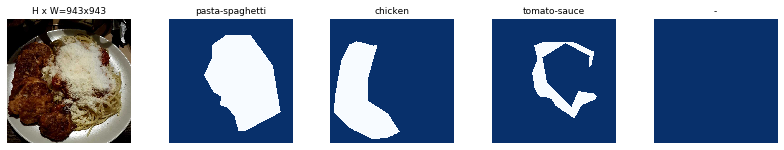

[INFO] Image ID: 15059


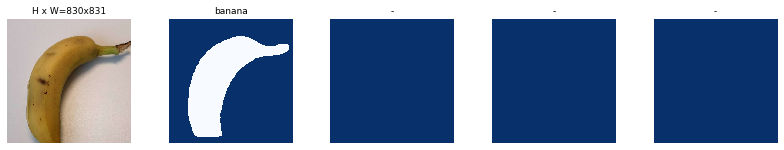

[INFO] Image ID: 15157


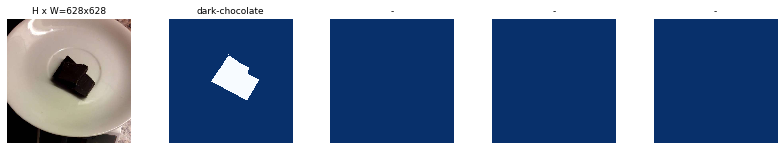

[INFO] Image ID: 119


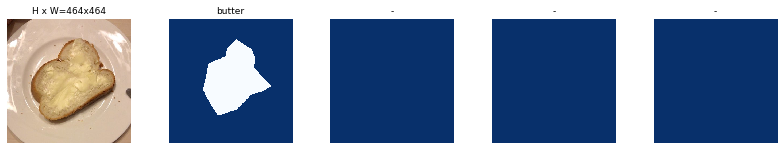

In [8]:
import numpy as np
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    print("[INFO] Image ID: {}".format(image_id))
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Resize Images

To support multiple images per batch, images are resized to one size (256x256). However aspect ratio is preserved. If an image is not square, then zero padding is added at the top/bottom or right/left.


[INFO] Image ID: 13514 	Dataset Reference: food-challenge::13514
[INFO] Original Shape:  (480, 480, 3)
[INFO] Image             shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
[INFO] Mask              shape: (256, 256, 1)         min:    0.00000  max:    1.00000  uint8
[INFO] Class IDs         shape: (1,)                  min:   15.00000  max:   15.00000  int32
[INFO] BBOX              shape: (1, 4)                min:   13.00000  max:  206.00000  int32


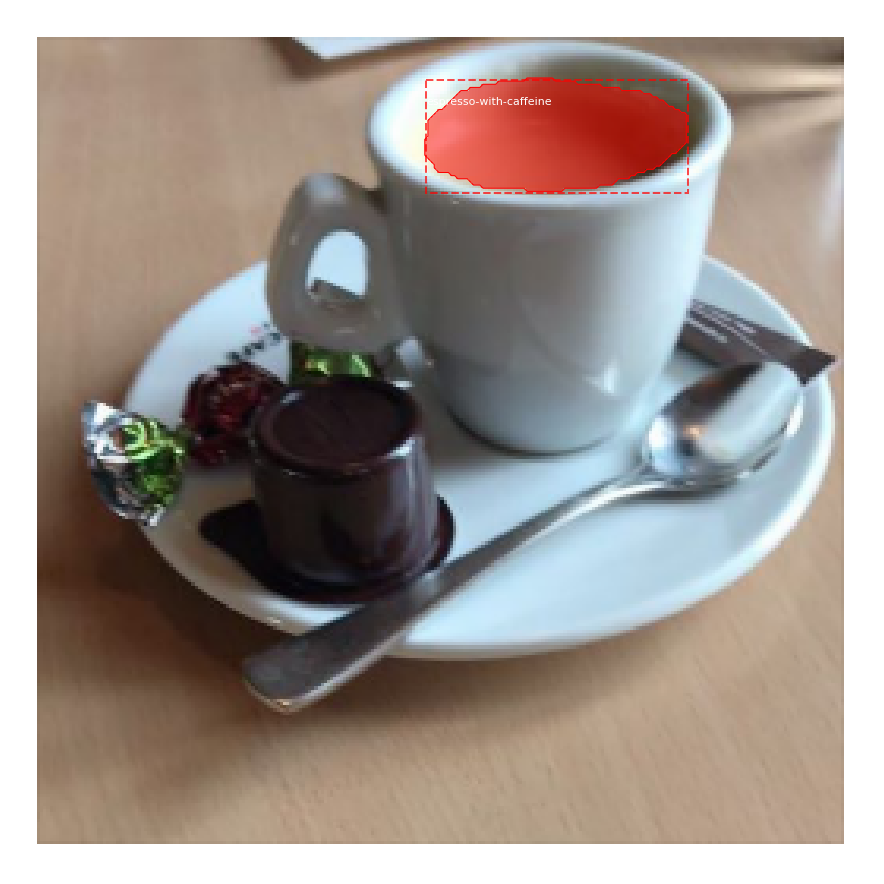

In [9]:
from mrcnn.model import log
# Load random image and mask.
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
original_shape = image.shape

# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("[INFO] Image ID: {} \tDataset Reference: {}".format(image_id, dataset_train.image_reference(image_id)))
print("[INFO] Original Shape: ", original_shape)
log("[INFO] Image", image)
log("[INFO] Mask", mask)
log("[INFO] Class IDs", class_ids)
log("[INFO] BBOX", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)


## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone.

To improve training speed, masks are optimized as:

* Mask pixels that are inside the object bounding box are stored, rather than a mask of the full image. Most objects are small compared to the image size, so space is saved by not storing a lot of zeros around the object.
* The mask is resized to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. However, this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.


[INFO] Image ID:  10289
[INFO] Image             shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
[INFO] Class IDs         shape: (1,)                  min:   40.00000  max:   40.00000  int32
[INFO] BBOX              shape: (1, 4)                min:   40.00000  max:  252.00000  int32
[INFO] Mask              shape: (256, 256, 1)         min:    0.00000  max:    1.00000  uint8
[INFO] Image Metas       shape: (53,)                 min:    0.00000  max: 10289.00000  float64


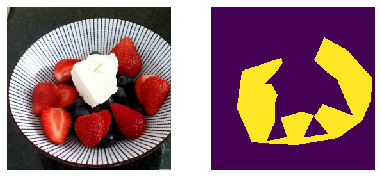

In [11]:
from mrcnn.visualize import display_images

image_id = np.random.choice(dataset_train.image_ids, 1)[0]
print("[INFO] Image ID: ", image_id)
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id, use_mini_mask=False)

log("[INFO] Image", image)
log("[INFO] Class IDs", class_ids)
log("[INFO] BBOX", bbox)
log("[INFO] Mask", mask)
log("[INFO] Image Metas", image_meta)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

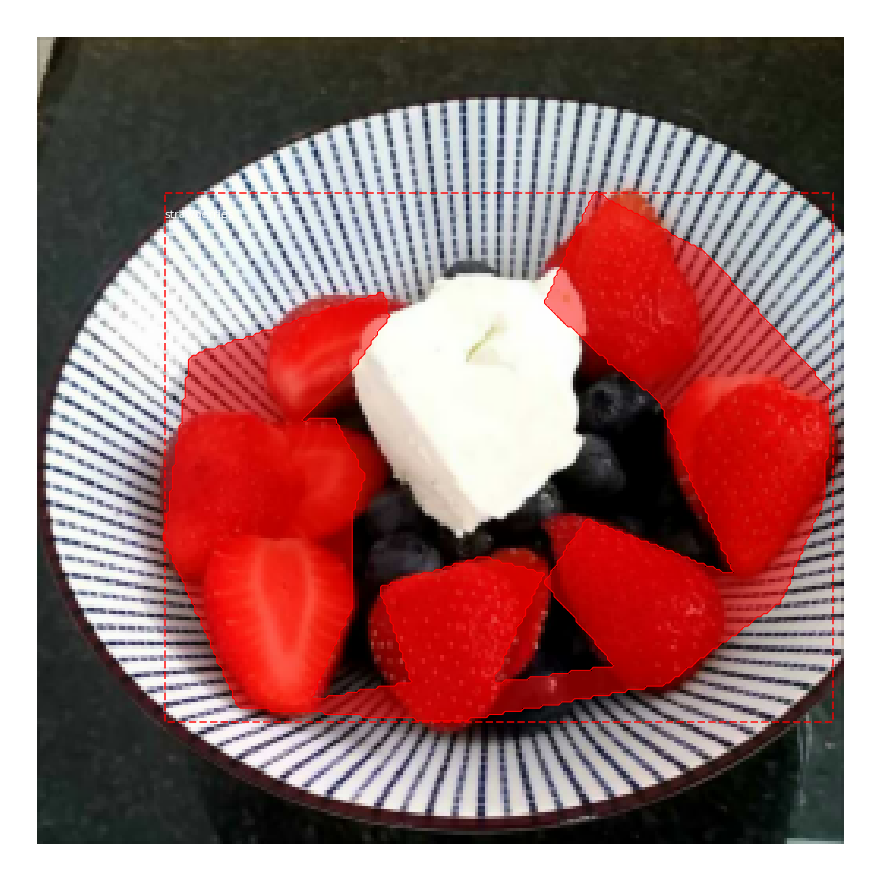

In [12]:
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

# Augmentations

Image augmentation is a strategy that allows us to significantly increase the diversity of images available for training models, without actually collecting new images. Augmentations make the model more robust.

[INFO] Mask              shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


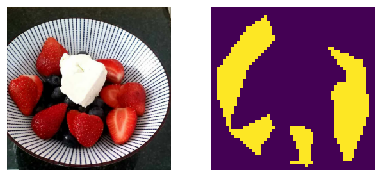

In [13]:
# Add augmentation and mask resizing.
import imgaug.augmenters as iaa

image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train,
    config,
    image_id,
    augmentation=iaa.flip.Fliplr(1.0),
    use_mini_mask=True
  )

log("[INFO] Mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

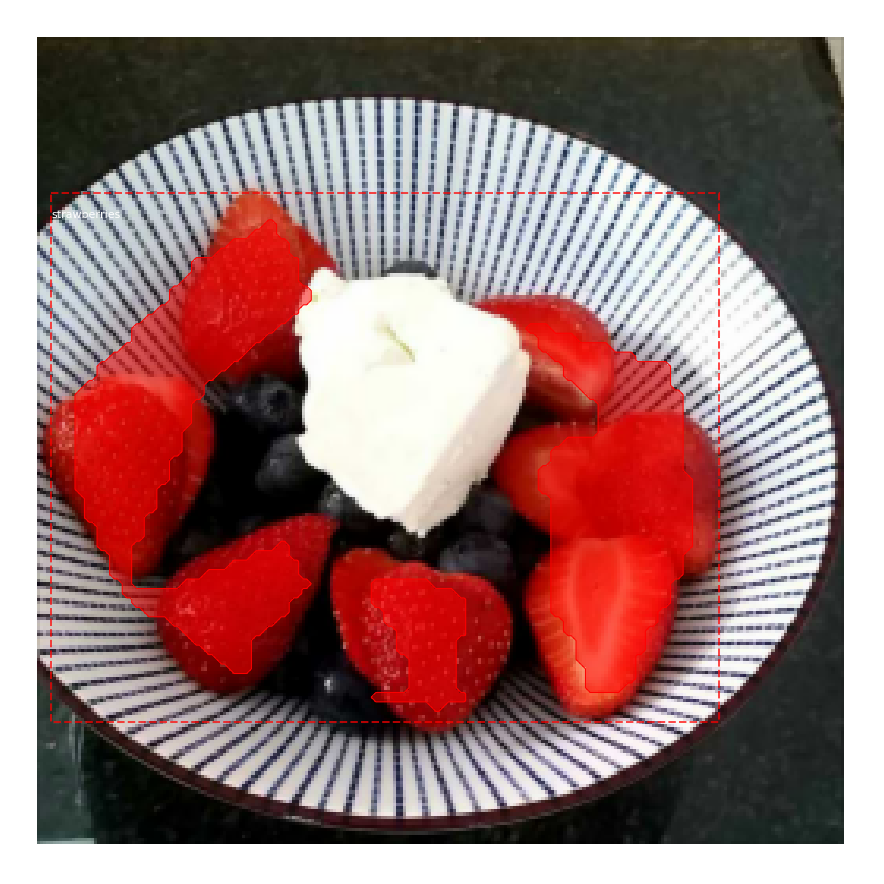

In [14]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

Detecting objects at different scales is challenging, even more so for small objects. We can use a pyramid of the same image at different scale to detect objects, as shown below. However this is a compute costly process and hence isn't used often. Alternatively, we create a pyramid of feature and use them for object detection.

![](https://github.com/RohitMidha23/Explained/blob/master/images/FPN.png?raw=True)

<center><a href="https://arxiv.org/pdf/1612.03144.pdf">Source</a></center>

For an Feature Pyramid Network (FPN) network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 

The order of anchors is important. The same order has to be used in training and prediction phases. This must also match the order of the convolution execution. This is internally taken care of by the MaskRCNN library.

* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:** In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256x256x3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example.

In this implementation we use an anchor stride of 2, which is different from the paper.


In [15]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(
    config.RPN_ANCHOR_SCALES, 
    config.RPN_ANCHOR_RATIOS,
    backbone_shapes,
    config.BACKBONE_STRIDES, 
    config.RPN_ANCHOR_STRIDE
  )

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("[INFO] Anchors Count: ", anchors.shape[0])
print("[INFO] Scales: ", config.RPN_ANCHOR_SCALES)
print("[INFO] Ratios: ", config.RPN_ANCHOR_RATIOS)
print("[INFO] Anchors per Cell: ", anchors_per_cell)
print("[INFO] Levels: ", num_levels)

anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors at Level {}: {}".format(l, anchors_per_level[l]))

[INFO] Anchors Count:  16368
[INFO] Scales:  (32, 64, 128, 256, 512)
[INFO] Ratios:  [0.5, 1, 2]
[INFO] Anchors per Cell:  3
[INFO] Levels:  5
Anchors at Level 0: 12288
Anchors at Level 1: 3072
Anchors at Level 2: 768
Anchors at Level 3: 192
Anchors at Level 4: 48


Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:     48  Feature map Shape: [4 4]


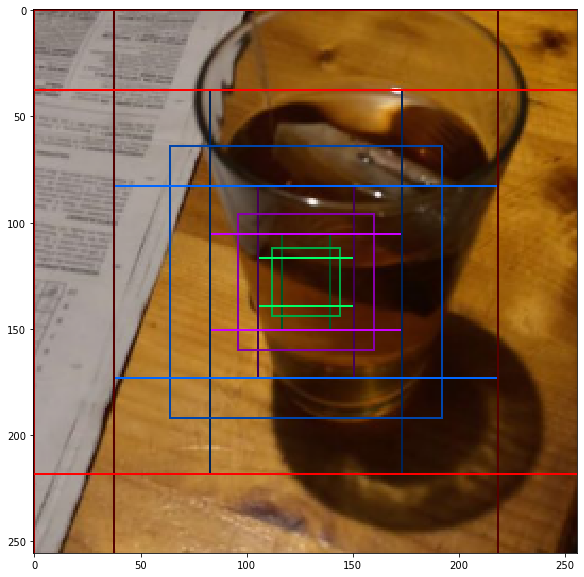

In [16]:
# Load and draw random image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset_train, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

# Data Gen

In [17]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset_train, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [18]:
# Uncomment to run the generator through a lot of images
# to catch rare errors

# from tqdm.notebook import tqdm
# count = 0
# for i in tqdm(range(1000)):
#     count+=1
#     _, _ = next(g)

# print(count)

In [19]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("[INFO] rois", rois)
    log("[INFO] mrcnn_class_ids", mrcnn_class_ids)
    log("[INFO] mrcnn_bbox", mrcnn_bbox)
    log("[INFO] mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("[INFO] gt_class_ids", gt_class_ids)
log("[INFO] gt_boxes", gt_boxes)
log("[INFO] gt_masks", gt_masks)
log("[INFO] rpn_match", rpn_match, )
log("[INFO] rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("[INFO] Image ID: {} \tDataset Reference: {}".format(image_id, dataset_train.image_reference(image_id)))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

[INFO] rois              shape: (4, 200, 4)           min:    0.00000  max:  255.00000  int32
[INFO] mrcnn_class_ids   shape: (4, 200, 1)           min:    0.00000  max:   20.00000  int32
[INFO] mrcnn_bbox        shape: (4, 200, 41, 4)       min:   -3.50962  max:    3.64706  float32
[INFO] mrcnn_mask        shape: (4, 200, 28, 28, 41)  min:    0.00000  max:    0.00000  float32
[INFO] gt_class_ids      shape: (4, 100)              min:    0.00000  max:   20.00000  int32
[INFO] gt_boxes          shape: (4, 100, 4)           min:    0.00000  max:  244.00000  int32
[INFO] gt_masks          shape: (4, 56, 56, 100)      min:    0.00000  max:    0.00000  bool
[INFO] rpn_match         shape: (4, 16368, 1)         min:   -1.00000  max:    1.00000  int32
[INFO] rpn_bbox          shape: (4, 256, 4)           min:   -1.17188  max:    1.32812  float64
[INFO] Image ID: 3261 	Dataset Reference: food-challenge::3261


anchors                  shape: (16368, 4)            min: -362.03867  max:  554.03867  float64
refined_anchors          shape: (3, 4)                min:   61.00000  max:  224.00000  float32
Positive anchors: 3
Negative anchors: 253
Neutral anchors: 16112
BG                     : 143
carrot                 : 57


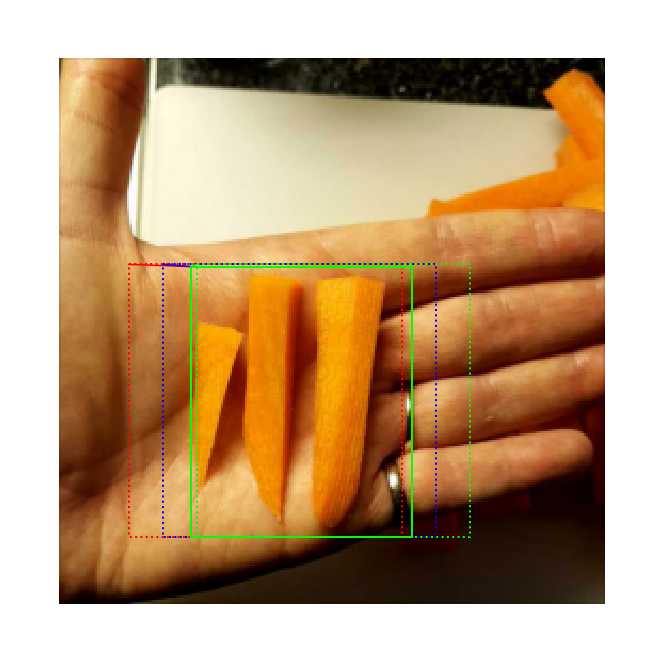

In [20]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset_train.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

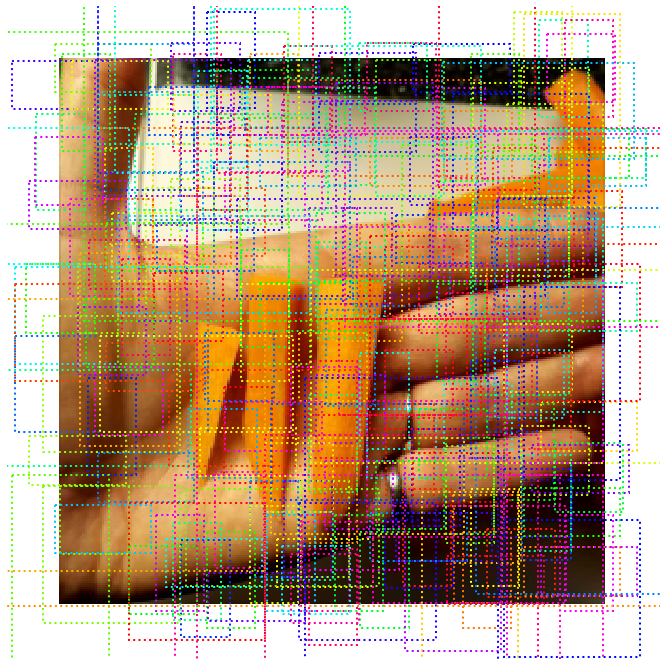

In [21]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

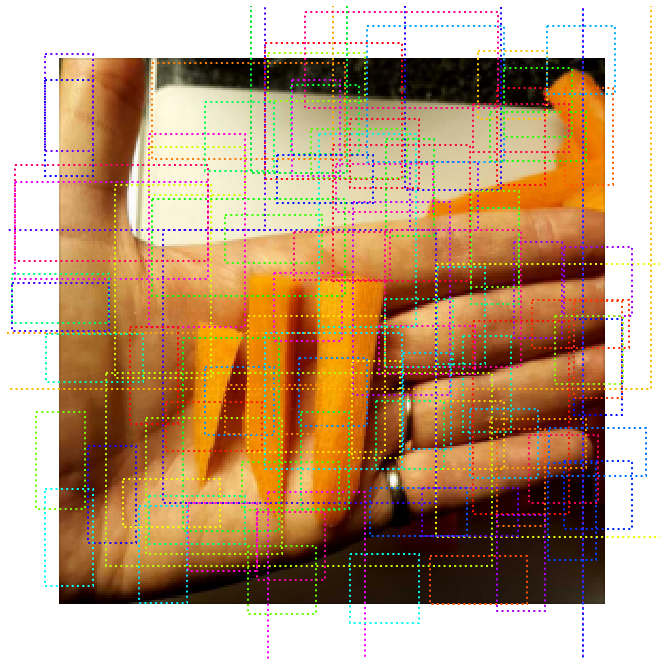

In [22]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  57
Negative ROIs:  143
Positive Ratio: 0.28
Unique ROIs: 200 out of 200


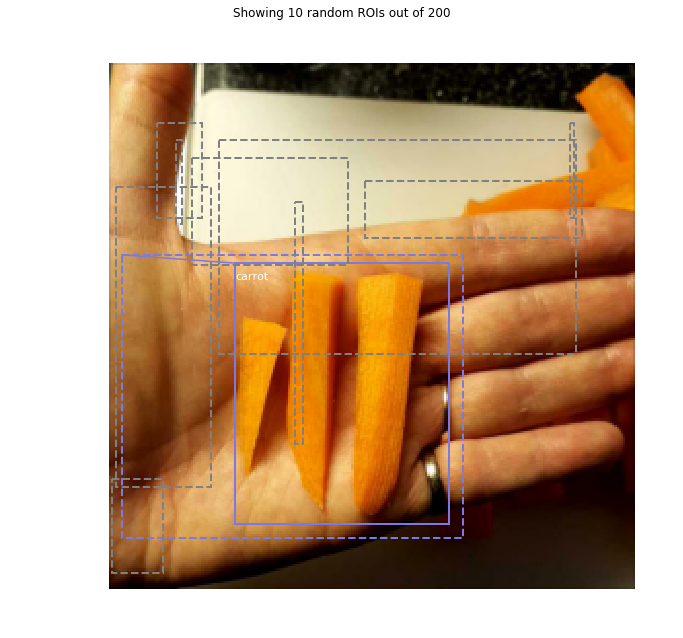

In [23]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset_train.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

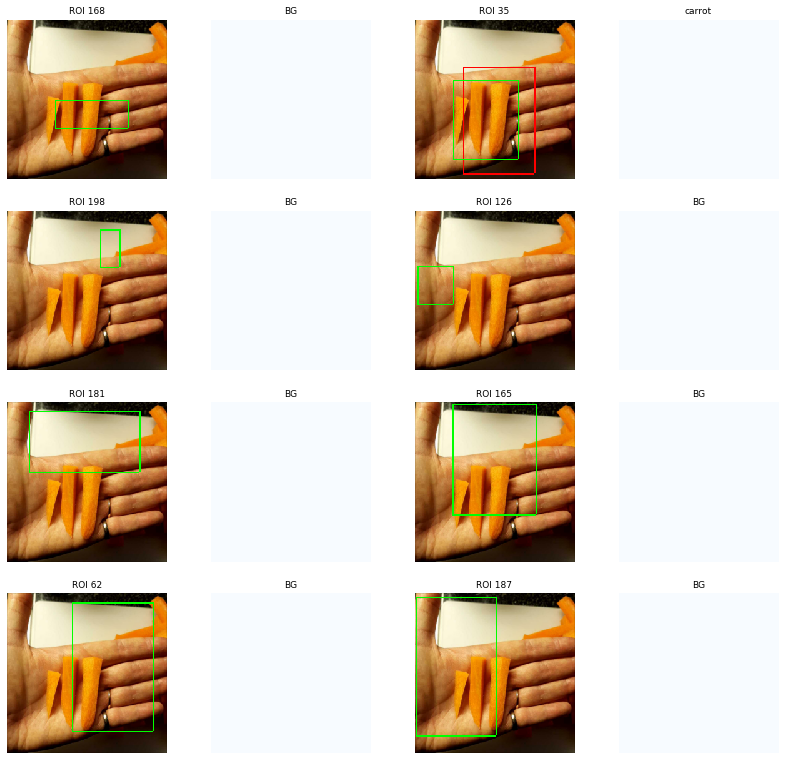

In [24]:
import random
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset_train.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [25]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset_train, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


## Authors

👾  [Shraddhaa Mohan](https://www.linkedin.com/in/shraddhaa-mohan-20a008185/)

🚀  [Rohit Midha](https://www.linkedin.com/in/rohitmidha/)